# ***Data Processing***

V. 1.09

In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import re
import pylab as pl
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')

In [2]:
movies = pd.DataFrame(pd.read_csv("movies.csv"))
movies = movies.drop(['Unnamed: 0'], axis=1)

movies.loc[movies["Year"] == '    ', ['Year']] = 0 
movies["Year"] = movies["Year"].fillna(-1)
movies["Year"] = movies["Year"].astype(float)

movies = movies[~movies['Budget'].astype(str).str.contains('Budget:')]
movies = movies[~movies['Budget'].astype(str).str.contains('Trivia')]
movies["Budget"] = movies["Budget"].str.replace(',','')
movies["Budget"] = movies["Budget"].fillna(-1)
movies["Budget"] = movies["Budget"].astype(float)

movies["Gross US"] = movies["Gross US"].str.replace(',','')
movies["Gross US"] = movies["Gross US"].fillna(-1)
movies["Gross US"] = movies["Gross US"].astype(float)

movies["Gross WW"] = movies["Gross WW"].str.replace(',','')
movies["Gross WW"] = movies["Gross WW"].fillna(-1)
movies["Gross WW"] = movies["Gross WW"].astype(float)

movies["Language"] = movies["Language"].fillna(-1)

movies["Rating"] = movies["Rating"].fillna('Unrated')

movies["Duration"] = movies["Duration"].fillna(-1)
movies=movies.rename(columns = {'Duration':'Duration_Minutes'})

movies=movies.rename(columns = {'Average Rating':'Average_Rating'})
print(movies.dtypes)

Name                   object
Year                  float64
Genres                 object
Rating                 object
Duration_Minutes      float64
Actors                 object
Director               object
Average_Rating        float64
Budget                float64
Opening Weekend       float64
Gross US              float64
Gross WW              float64
Language               object
Production Company     object
dtype: object


In [3]:
#Cleaning Rating
drop_tv = ['TV-14' ,'TV-G', 'TV-MA', 'TV-Y', 'TV-PG' , 'TV-Y7' , 'GP' , 'Passed' , 'X' ]  #Removing TV shows/X rated movies
movies=movies[~movies['Rating'].isin(drop_tv)]
movies['Rating'] = movies['Rating'].replace({'Not Rated':'Unrated'})
movies["Rating"].value_counts()

R          3974
PG-13      2020
PG         1570
Unrated    1360
G           252
NC-17        20
Name: Rating, dtype: int64

In [4]:
#Cleaning Year
to_drop = [2020,2021,2024] #Removing future releases (no data available)
movies=movies[~movies['Year'].isin(to_drop)] 

In [5]:
#Calculating Profit/Loss for each movie
movies["Profit"] = movies["Gross US"]+movies["Gross WW"]- movies["Budget"]
movies["Status"]= np.where(movies['Profit']>1, 'Success', 'Failure')
movies["Status"].value_counts()

Success    4942
Failure    4242
Name: Status, dtype: int64

In [6]:
movies["Genres"] = movies["Genres"].str.replace('[','')
movies["Genres"] = movies["Genres"].str.replace(']','')
movies["Genres"] = movies["Genres"].str.replace("'",'')
movies["Actors"] = movies["Actors"].str.replace('[','')
movies["Actors"] = movies["Actors"].str.replace(']','')
movies["Actors"] = movies["Actors"].str.replace("'",'')
movies["Director"] = movies["Director"].str.replace('[','')
movies["Director"] = movies["Director"].str.replace(']','')
movies["Director"] = movies["Director"].str.replace("'",'')
movies["Production Company"] = movies["Production Company"].str.replace('[','')
movies["Production Company"] = movies["Production Company"].str.replace(']','')
movies["Production Company"] = movies["Production Company"].str.replace("'",'')
movies["Language"] = movies["Language"].str.replace('[','')
movies["Language"] = movies["Language"].str.replace(']','')
movies["Language"] = movies["Language"].str.replace("'",'')
# movies.head()

In [7]:
indexNames = movies[ (movies['Year'] == 0) & (movies['Rating'] == 'Unrated')&(movies['Budget'] != -1) ].index
# Delete these row indexes from dataFrame
movies.drop(indexNames , inplace=True)

In [8]:
g = (movies.Genres.str.split(',', expand=True)
            .stack()
            .to_frame(name='genre'))
g.index = g.index.droplevel(1)
g["genre"] = g["genre"].str.replace(' ','')
g["genre"] = g["genre"].str.replace('}','')
# m=movies.join(g)
movies=pd.concat([movies, g], axis=1)
movies.head().T

,0,0,1,1,1
Name,Pulp Fiction,Pulp Fiction,The Amazing Spider-Man 2,The Amazing Spider-Man 2,The Amazing Spider-Man 2
Year,1994,1994,2014,2014,2014
Genres,"Crime, Drama","Crime, Drama","Action, Adventure, Sci-Fi","Action, Adventure, Sci-Fi","Action, Adventure, Sci-Fi"
Rating,R,R,PG-13,PG-13,PG-13
Duration_Minutes,154,154,142,142,142
Actors,"John Travolta, Uma Thurman, Samuel L. Jackson,...","John Travolta, Uma Thurman, Samuel L. Jackson,...","Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...","Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...","Andrew Garfield, Emma Stone, Jamie Foxx, Paul ..."
Director,Quentin Tarantino,Quentin Tarantino,Marc Webb,Marc Webb,Marc Webb
Average_Rating,8.9,8.9,6.6,6.6,6.6
Budget,8e+06,8e+06,2e+08,2e+08,2e+08
Opening Weekend,9.31188e+06,9.31188e+06,9.16083e+07,9.16083e+07,9.16083e+07


In [9]:
genre_count = movies['genre'].value_counts().sort_index()
genre_count

                  6
Action         1885
Adventure      1438
Animation       336
Biography       799
Comedy         3475
Crime          1713
Documentary     282
Drama          4876
Family          825
Fantasy         956
History         440
Horror         1122
Music           398
Musical         234
Mystery         890
News              6
Reality-TV        6
Romance        1994
Sci-Fi          988
Short             8
Sport           341
Talk-Show         1
Thriller       2500
War             369
Western         174
actor           578
creator          89
director         56
Name: genre, dtype: int64

In [11]:
drop_geners = ['Musical' ,'Sport', 'History', 'Music','News', 'Reality-TV', 'Talk-Show' , '' ] #Removing TV shows/reality/sport
movies=movies[~movies['genre'].isin(drop_geners)]
movies["genre"].value_counts()

Drama          4876
Comedy         3475
Thriller       2500
Romance        1994
Action         1885
Crime          1713
Adventure      1438
Horror         1122
Sci-Fi          988
Fantasy         956
Mystery         890
Family          825
Biography       799
actor           578
War             369
Animation       336
Documentary     282
Western         174
creator          89
director         56
Short             8
Name: genre, dtype: int64

In [ ]:
movies.info()
movies.to_excel('Test.xlsx')

In [12]:
movies.isnull().sum()

Name                      0
Year                      0
Genres                    0
Rating                    0
Duration_Minutes          0
Actors                    0
Director                  0
Average_Rating            0
Budget                    0
Opening Weekend       10497
Gross US                  0
Gross WW                  0
Language                433
Production Company        0
Profit                    0
Status                    0
genre                     0
dtype: int64

In [ ]:
# movies["Language"].value_counts()

Filling NA with median value

In [ ]:
# def fill_nan(col):
#     movies[col] = movies[col].fillna(movies[col].median())

# cols = list(movies.columns)
# fill_nan(cols)

In [ ]:
movies.columns

In [13]:
movies.Name.value_counts() #multiple movies with same name ..but each was made in different year with different cast
df=movies.groupby(['Name'], as_index=False).size()
df.to_frame()
df.to_excel('test1.xlsx')

# Visualization

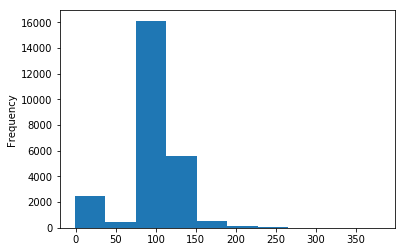

In [14]:
# create a histogram of duration, choosing an “appropriate” number of bins
movies['Duration_Minutes'].plot(kind='hist', bins=10)

In [ ]:
movies['Duration_Minutes'].plot(kind='box')

Count how many movies have average ratings :

In [ ]:
# movies[['Average_Rating' ,'Name']].groupby('Average_Rating').count()
imdbScore=[[]]
x=[]

for i in pl.frange(1,9.5,.5):
    imdbScore.append(len(movies.Average_Rating[(movies.Average_Rating>=i) & (movies.Average_Rating<i+.5)]))
    x.append(i)

del(imdbScore[0])

plt.figure(figsize=(15,12))
plt.title("Histogram Of IMDB Score")
plt.ylabel("IMDB Score")
plt.xlabel('Frequency')
plt.barh(x,imdbScore,height=.45 ,color='green')
plt.yticks(x)
plt.show()

In [ ]:
data=movies.dropna()
year=(movies.Year.unique()).astype(int)
year=sorted(year)

yearImdbScore=[]
numOfMovieByYear=[]

for i in year:
    tmp=movies.Average_Rating[movies.Year==i]
    yearImdbScore.append(tmp)
    numOfMovieByYear.append(len(tmp))



plt.figure(figsize=(15,10))
plt.title("IMDB Score Vs Year")
plt.ylabel("IMDB Score")
plt.xlabel('Year')
plt.boxplot(yearImdbScore,widths=.75)
year=list(np.insert(year,0,0))
plt.xticks(range(len(year)),year,rotation=90,fontsize=10)
plt.show()


Top Director VS Their Movie imdb rating

In [ ]:
director=list(movies.Director.unique())
df=pd.DataFrame(columns=['director','directorScoreMean','directorImdbScore','directorMovieNUm'])

for i in director:
    tmp=list(movies.Average_Rating[movies.Director==i])
    if len(tmp)>1:
         df=df.append({'director': i,'directorScoreMean': sum(tmp)/len(tmp),'directorImdbScore': tmp,'directorMovieNUm' :len(tmp)},ignore_index=True)
    
tmp=(df.sort_values(['directorScoreMean'],ascending=False)).head(25)
directorByMeanScore=list(tmp.director)
directorByMeanScore.reverse()
ScoreByMeanScore=list(tmp.directorImdbScore)
ScoreByMeanScore.reverse()


tmp=(df.sort_values(['directorMovieNUm'],ascending=False)).head(25)
directorByMovieNum =list(tmp.director)
directorByMovieNum.reverse()
ScoreByMovieNum=list(tmp.directorImdbScore)
ScoreByMovieNum.reverse()

In [ ]:
#directorByMovieNum
plt.figure(figsize=(11,11))
for i in range(len(directorByMovieNum)):
    for j in ScoreByMovieNum[i]:
        plt.scatter(i,j,c=j,vmin=3,vmax=10)


#tmp=plt.scatter(c=ScoreByMovieNum)
plt.colorbar(fraction=.04)
plt.title("Top Director vs Their IMDB Rating ")
plt.ylabel('Movies IMDB Rating')
plt.xlabel("\nDirector's Name")
plt.xticks(range(25),directorByMovieNum,rotation=90)

plt.show()

In [ ]:
#directorByMeanScore
plt.figure(figsize=(11,11))
for i in range(len(directorByMeanScore)):
    for j in ScoreByMeanScore[i]:
        plt.scatter(i,j,c=j,vmin=6,vmax=10)

plt.xticks(range(25),directorByMeanScore,rotation=90)
plt.title("Top Director vs Their IMDB Score\n Interm Of Their Average IMDB Score ")
plt.ylabel('Movies IMDB Score')
plt.xlabel("\nDirector's Name")
plt.colorbar(fraction=.04)
plt.show()

In [ ]:
# use a visualization to display that same data, including a title and x and y labels
movies[['Rating' ,'Name']].groupby('Rating').count().plot(kind='bar', title='Content Rating Visualization')
plt.xlabel('Content Rating')
plt.ylabel('Title Count')

In [ ]:
# calculate the average star rating for movies 2 hours or longer,
# and compare that with the average star rating for movies shorter than 2 hours
print('Avg. star rating for movies 2 hours or longer: ', movies[movies['Duration_Minutes'] >= 120]['Average_Rating'].mean(), 
 '\nAvg. star rating for movies shorter than 2 hours: ', movies[movies['Duration_Minutes'] < 120]['Average_Rating'].mean())

In [ ]:
# use a visualization to detect whether there is a relationship between duration and star rating
movies.boxplot(column='Duration_Minutes', by='Average_Rating');

In [26]:
movies[['Profit','genre']].groupby('genre')

In [ ]:
# visualize the relationship between content rating and duration
movies.boxplot(column='Duration_Minutes', by='Rating')

Check for Duplicacy

In [15]:
# check if there are multiple movies with the same title, and if so, determine if they are actually duplicates
result = movies[movies['Name'].isin(movies[movies.duplicated(['Name'])]['Name'])]
result.sort_values('Name')

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company,Profit,Status,genre
4680,$5 a Day,2008.0,"Comedy, Drama",PG-13,90.0,"Christopher Walken, Alessandro Nivola, Sharon ...",Nigel Cole,6.4,-1.0,NaN,-1.0,-1.0,English,"CapitolFilms, AramidEntertainmentFund, CarolBa...",-1.0,Failure,Drama
4680,$5 a Day,2008.0,"Comedy, Drama",PG-13,90.0,"Christopher Walken, Alessandro Nivola, Sharon ...",Nigel Cole,6.4,-1.0,NaN,-1.0,-1.0,English,"CapitolFilms, AramidEntertainmentFund, CarolBa...",-1.0,Failure,Comedy
6636,(500) Days of Summer,2009.0,"Comedy, Drama, Romance",PG-13,95.0,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",Marc Webb,7.7,7500000.0,834501.0,32391374.0,60722734.0,"English, French, Swedish","FoxSearchlightPictures, Watermark, DuneEnterta...",85614108.0,Success,Comedy
6636,(500) Days of Summer,2009.0,"Comedy, Drama, Romance",PG-13,95.0,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",Marc Webb,7.7,7500000.0,834501.0,32391374.0,60722734.0,"English, French, Swedish","FoxSearchlightPictures, Watermark, DuneEnterta...",85614108.0,Success,Drama
6636,(500) Days of Summer,2009.0,"Comedy, Drama, Romance",PG-13,95.0,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",Marc Webb,7.7,7500000.0,834501.0,32391374.0,60722734.0,"English, French, Swedish","FoxSearchlightPictures, Watermark, DuneEnterta...",85614108.0,Success,Romance
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",Matthew Robbins,6.6,-1.0,3326530.0,32945797.0,65088797.0,English,"UniversalPictures, AmblinEntertainment",98034595.0,Success,Comedy
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",Matthew Robbins,6.6,-1.0,3326530.0,32945797.0,65088797.0,English,"UniversalPictures, AmblinEntertainment",98034595.0,Success,Family
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",Matthew Robbins,6.6,-1.0,3326530.0,32945797.0,65088797.0,English,"UniversalPictures, AmblinEntertainment",98034595.0,Success,Fantasy
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",Matthew Robbins,6.6,-1.0,3326530.0,32945797.0,65088797.0,English,"UniversalPictures, AmblinEntertainment",98034595.0,Success,Sci-Fi
3426,...and justice for all.,1979.0,"Crime, Drama, Thriller",R,119.0,"Al Pacino, Jack Warden, John Forsythe, Lee Str...",Norman Jewison,7.4,-1.0,NaN,33300000.0,-1.0,English,ColumbiaPicturesCorporation,33300000.0,Success,Drama


In [ ]:
# calculate the average star rating for each genre, but only include genres with at least 10 movies
genres = movies['Genres'].value_counts()[movies['Genres'].value_counts() > 10].index
movies[movies['Genres'].isin(genres)].groupby('Genres')['Average_Rating'].mean()

In [ ]:
# Make a function which clean the data
def repp(string):
    return string.replace("'","").replace(",",",")[:-1]
#Apply that function to every entry    
movies_series = movies['Actors'].apply(repp)
#Declare a list to store the split values
actors_list = []
for movie_actors in movies_series:
    actors_list.append([e.strip() for e in movie_actors.split(',')])
#Declare a dictionary and see if the actor name key exist and then count accordingly.
actor_dict = {}
for actor in actors_list:
    for a in actor:
        if a in actor_dict:
            actor_dict[a] +=1
        else:
            actor_dict[a] = 1

actor_dict

In [ ]:
#Sorted list of Actors
import operator
actor_movie_count = sorted(actor_dict.items(), key=operator.itemgetter(1))
actor_movie_count

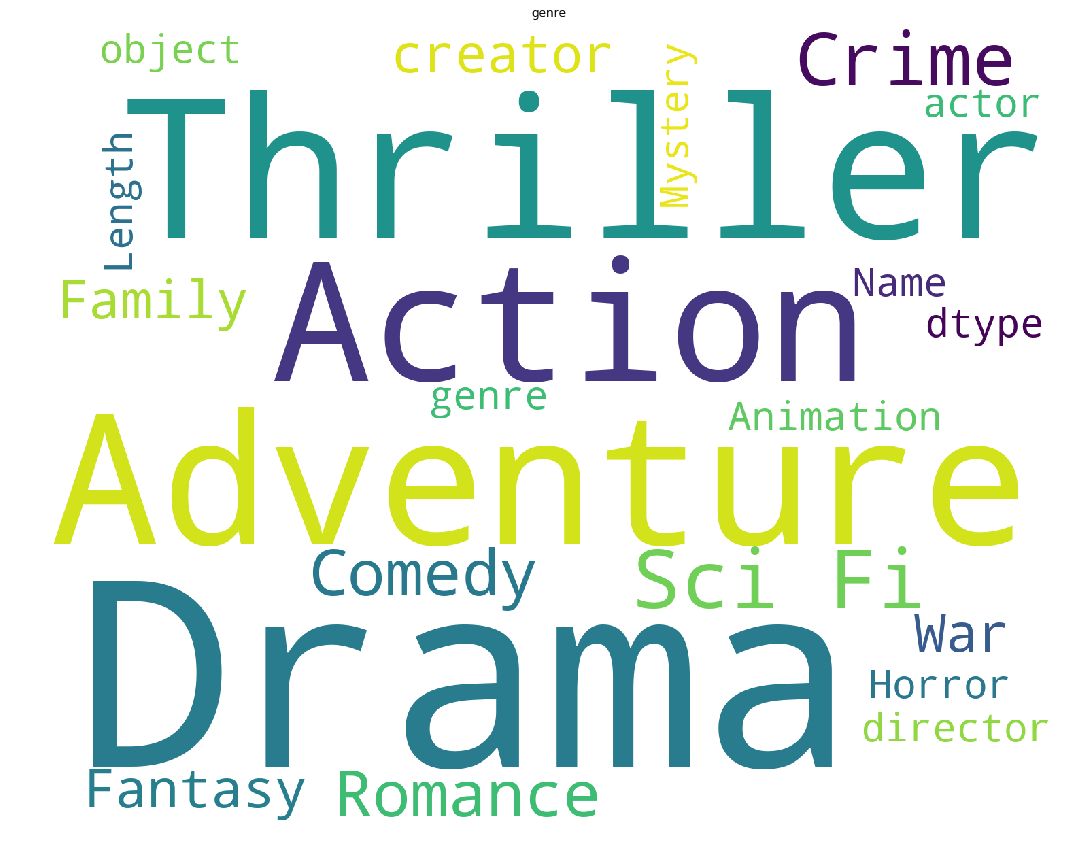

In [27]:
import random
from wordcloud import WordCloud, STOPWORDS
text = (str(movies['genre']))
plt.subplots(figsize=(20,15))
wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1500,
                          height=1200
                         ).generate(text)


plt.imshow(wordcloud)
plt.title('genre')
plt.axis('off')
plt.show()

In [28]:
movies["genre"].value_counts()

Drama          4876
Comedy         3475
Thriller       2500
Romance        1994
Action         1885
Crime          1713
Adventure      1438
Horror         1122
Sci-Fi          988
Fantasy         956
Mystery         890
Family          825
Biography       799
actor           578
War             369
Animation       336
Documentary     282
Western         174
creator          89
director         56
Short             8
Name: genre, dtype: int64

In [ ]:
# movies.Director.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(10,10))
# # plt.title('TOP 10 Directors OF MOVIES')

In [ ]:
# movies.Actors.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(10,10))
# plt.title('TOP 10 Actors OF MOVIES')

In [ ]:
# movies["Year"].value_counts().to_frame()

In [35]:
g=movies.groupby('Year')
g.count().head(10)

,Name,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company,Profit,Status,genre
Year,,,,,,,,,,,,,,,,
0.0,837,837,837,837,837,837,837,837,0,837,837,411,837,837,837,837
1970.0,28,28,28,28,28,28,28,28,0,28,28,28,28,28,28,28
1971.0,8,8,8,8,8,8,8,8,0,8,8,8,8,8,8,8
1972.0,124,124,124,124,124,124,124,124,6,124,124,124,124,124,124,124
1973.0,379,379,379,379,379,379,379,379,16,379,379,379,379,379,379,379
1974.0,312,312,312,312,312,312,312,312,5,312,312,312,312,312,312,312
1975.0,315,315,315,315,315,315,315,315,12,315,315,315,315,315,315,315
1976.0,323,323,323,323,323,323,323,323,12,323,323,322,323,323,323,323
1977.0,321,321,321,321,321,321,321,321,22,321,321,321,321,321,321,321


In [ ]:
#top 10 rating movies 
Sortedrating= movies.sort_values(['Average_Rating'], ascending=False)
Sortedrating.head(10)

In [ ]:
# low rated movies
lowratedmovies= movies.query('(Average_Rating > 0) & (Average_Rating < 3.0)')
lowratedmovies.head()

In [ ]:
Sortedrevenue= movies.sort_values(['Budget'], ascending=False)

In [ ]:
#top 5 high revenue movies
Sortedrevenue.head()

In [ ]:
m= Sortedrevenue.query('(Budget > 500)')
print('number of movies with more than half million revenue:')
len(m)

In [ ]:
n= Sortedrevenue.query('(Budget < 500)')
print('number of movies with less than half million revenue:')
len(n)

In [ ]:
movies.info()

In [ ]:
# from wordcloud import WordCloud, STOPWORDS
# plt.subplots(figsize=(10,10))
# text = (str(m['Actors']))
# wordcloud = WordCloud(
#                           stopwords=STOPWORDS,
#                           background_color='white',
#                           width=1200,
#                           height=1000
#                          ).generate(text)


# plt.imshow(wordcloud)
# plt.title('ACTORS IN HIGH REVENUE MOVIES')
# plt.axis('off')
# plt.show()

In [ ]:
# from wordcloud import WordCloud, STOPWORDS
# plt.subplots(figsize=(10,10))
# text = (str(n['Actors']))
# wordcloud = WordCloud(
#                           stopwords=STOPWORDS,
#                           background_color='white',
#                           width=1200,
#                           height=1000
#                          ).generate(text)


# plt.imshow(wordcloud)
# plt.title('ACTORS IN LOW REVENUE MOVIES')
# plt.axis('off')
# plt.show()

In [33]:
numeric_features=movies._get_numeric_data().columns.values.tolist()
numeric_features

['Year',
 'Duration_Minutes',
 'Average_Rating',
 'Budget',
 'Opening Weekend',
 'Gross US',
 'Gross WW',
 'Profit']

# Correlation heatmap

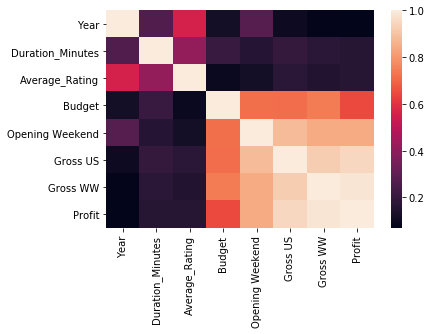

In [32]:
col = list(movies.describe().columns)
features=col
features
sns.heatmap(movies[features].corr())

In [ ]:
correlation=movies.corr()
correlation

In [ ]:
movies.head()

# Rating Replacement with Monitary Value

In [ ]:
#Need to change all movie ratings that are NC-17 to Unrated
movies["Rating"] = movies["Rating"].replace('NC-17', 'Unrated')

In [ ]:
#Graphing R rating vs Gross Earning distrubition
R = movies[movies["Rating"] == 'R']
R = R[R["Gross US"] > 0]
R = R.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingR = R.groupby(pd.cut(R["Gross US"], groups)).count()
y_pos = np.arange(len(groupingR))
plt.barh(y_pos , groupingR["Gross US"], 1/1.5, color="blue")
plt.title("R rating Distribtion")
plt.show()
print("Mean Value: ", R["Gross US"].mean())

In [ ]:
#Graphing PG13 rating vs Gross Earning distrubition
PG13 = movies[movies["Rating"] == 'PG-13']
PG13 = PG13[PG13["Gross US"] > 0]
PG13 = PG13.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingPG13 = PG13.groupby(pd.cut(PG13["Gross US"], groups)).count()
y_pos = np.arange(len(groupingPG13))
plt.barh(y_pos , groupingPG13["Gross US"], 1/1.5, color="blue")
plt.title("PG-13 rating Distribtion")
plt.show()
print("Mean Value: ", PG13["Gross US"].mean())

In [ ]:
#Graphing PG rating vs Gross Earning distrubition
PG = movies[movies["Rating"] == 'PG']
PG = PG[PG["Gross US"] > 0]
PG = PG.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingPG = PG.groupby(pd.cut(PG["Gross US"], groups)).count()
y_pos = np.arange(len(groupingPG))
plt.barh(y_pos , groupingPG["Gross US"], 1/1.5, color="blue")
plt.title("PG rating Distribtion")
plt.show()
print("Mean Value: ", PG["Gross US"].mean())

In [ ]:
#Graphing G rating vs Gross Earning distrubition
G = movies[movies["Rating"] == 'G']
G = G[G["Gross US"] > 0]
G = G.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingG = G.groupby(pd.cut(G["Gross US"], groups)).count()
y_pos = np.arange(len(groupingG))
plt.barh(y_pos , groupingG["Gross US"], 1/1.5, color="blue")
plt.title("G rating Distribtion")
plt.show()
print("Mean Value: ", G["Gross US"].mean())

In [ ]:
#Graphing Unrated rating vs Gross Earning distrubition
UN = movies[movies["Rating"] == 'Unrated']
UN = UN[UN["Gross US"] > 0]
UN = UN.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingUN = UN.groupby(pd.cut(UN["Gross US"], groups)).count()
y_pos = np.arange(len(groupingUN))
plt.barh(y_pos , groupingUN["Gross US"], 1/1.5, color="blue")
plt.title("Unrated rating Distribtion")
plt.show()
print("Mean Value: ", UN["Gross US"].mean())

In [ ]:
#Checking to see if teh ratings are statiscally different are statistically different
print("R-PG13: ", stats.ttest_ind(R["Gross US"], PG13["Gross US"], equal_var = False))
print("R-PG: ", stats.ttest_ind(R["Gross US"], PG["Gross US"], equal_var = False))
print("R-G: ", stats.ttest_ind(R["Gross US"], G["Gross US"], equal_var = False))
print("PG13-PG: ", stats.ttest_ind(PG13["Gross US"], PG["Gross US"], equal_var = False))
print("PG13-G: ", stats.ttest_ind(PG13["Gross US"], G["Gross US"], equal_var = False))
print("PG-G: ", stats.ttest_ind(PG["Gross US"], G["Gross US"], equal_var = False))
print("UN-R: ", stats.ttest_ind(UN["Gross US"], R["Gross US"], equal_var = False))
print("UN-PG13: ", stats.ttest_ind(UN["Gross US"], PG13["Gross US"], equal_var = False))
print("UN-PG: ", stats.ttest_ind(UN["Gross US"], PG["Gross US"], equal_var = False))
print("UN-G: ", stats.ttest_ind(UN["Gross US"], G["Gross US"], equal_var = False))

Statiscally non of these values with high accuracy are equal to eachother. This allows us to say that each rating has statiscally different value. Lets now replace the Rating with the value of the mean of the rating to signify the value that the rating has upon the movie.

In [ ]:
movies.head()

# PREDICTION

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split
from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn import linear_model

import warnings
warnings.filterwarnings("ignore")

In [ ]:
movies.fillna(value=0,axis=1,inplace=True)
print(movies.set_index(['Budget','Opening Weekend','Gross US'])
         .stack()
         .reset_index(name='value')
         )

In [ ]:
features = ['Rating','Budget', 'Opening Weekend']
target = ['Gross US']

In [ ]:
train, test = train_test_split(movies,test_size=0.30)


In [ ]:
#Fill the training and test data with require information
train_x = train[features] 
train_y = train[target]
test_x = test[features]
test_y = test[target]

In [ ]:
R = train_y[train_x["Rating"] == 'R']
PG13 = train_y[train_x["Rating"] == 'PG-13']
PG = train_y[train_x["Rating"] == 'PG']
G = train_y[train_x["Rating"] == 'G']
UN = train_y[train_x["Rating"] == 'Unrated']

#a baseline for the value of movies made in that rating
train_x["Rating"] = train_x["Rating"].replace('R', R["Gross US"].mean())
train_x["Rating"] = train_x["Rating"].replace('PG-13', PG13["Gross US"].mean())
train_x["Rating"] = train_x["Rating"].replace('PG', PG["Gross US"].mean())
train_x["Rating"] = train_x["Rating"].replace('G', G["Gross US"].mean())
train_x["Rating"] = train_x["Rating"].replace('Unrated', UN["Gross US"].mean())
train_x["Rating"] = train_x["Rating"].astype(float)
#a baseline for the value of movies made in that rating
test_x["Rating"] = test_x["Rating"].replace('R', R["Gross US"].mean())
test_x["Rating"] = test_x["Rating"].replace('PG-13', PG13["Gross US"].mean())
test_x["Rating"] = test_x["Rating"].replace('PG', PG["Gross US"].mean())
test_x["Rating"] = test_x["Rating"].replace('G', G["Gross US"].mean())
test_x["Rating"] = test_x["Rating"].replace('Unrated', UN["Gross US"].mean())
test_x["Rating"] = test_x["Rating"].astype(float)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_x_std = pd.DataFrame(sc.fit_transform(train_x),columns=features)
test_x_std = pd.DataFrame(sc.transform(test_x), columns=features)


In [ ]:
train_x_std.head(2)

In [ ]:
corr = train_x_std.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
            cmap= 'YlGnBu')

In [ ]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(train_x_std,train_y)
predicted_rating = model.predict(test_x_std)

In [ ]:
#Calculate cross valiation scores
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, train_x_std, train_y, cv=5)
print("Linear regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
#Calculate score of the model
from sklearn import metrics 
r2score  = metrics.r2_score(test_y,predicted_rating)
print('R2 score is:{} best score is 1.00 and worst is 0.00'.format(round(r2score,2)))

In [ ]:
high_score_data= movies.loc[movies['Gross US']>=3] #only count of movies with score>= 3.0
sns.countplot(high_score_data['Gross US'],label='Gross US')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
train_y = np.asarray(train_y, dtype="|S6")
test_y = np.asarray(test_y,dtype="|S6")
rf.fit(train_x_std,np.ravel(train_y))
predictions = rf.predict(test_x_std)

In [ ]:
#Calculate cross valiation scores
from sklearn.model_selection import cross_val_score
print(test_y.shape)
scores = cross_val_score(rf, test_x_std,np.ravel(test_y), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('Maximum score in cross valuation is: %0.2f'%(scores.max()))

In [ ]:
ser = pd.Series(rf.feature_importances_,index=features) #feature importance
ser.sort_values(ascending=False,inplace=True)
ser.plot(kind='bar')